# Reinforcement Learning: Multi-Armed Bandits Project

This project implements and analyzes Multi-Armed Bandit (MAB) algorithms, including contextual and non-contextual variants. The project explores exploration-exploitation tradeoffs and implement various bandit strategies for sequential decision-making under uncertainty.

## Problem Statement

The Multi-Armed Bandit problem is a fundamental challenge in reinforcement learning that models the exploration-exploitation dilemma. The problem is inspired by a gambler facing multiple slot machines (one-armed bandits) and must decide which machine to play to maximize rewards over time. The key challenge is balancing:

- **Exploration**: Trying different arms to gather information about their reward distributions
- **Exploitation**: Using the knowledge gained to play the arm that appears most rewarding

This tradeoff is critical because:
- Playing only the currently best arm (pure exploitation) may miss better options
- Playing all arms equally (pure exploration) wastes opportunities on clearly inferior arms
- The optimal strategy adapts over time, exploring more early on and exploiting more as confidence grows

## Multi-Armed Bandit

A **Multi-Armed Bandit (MAB)** is a sequential decision-making framework where:

1. **Arms**: Multiple actions or choices (e.g., different slot machines, ad variants, treatment options)
2. **Rewards**: Each arm provides a stochastic reward when selected, drawn from an unknown probability distribution
3. **Goal**: Maximize cumulative reward over a sequence of rounds by learning which arms are most rewarding

**Key Characteristics:**
- **Non-stationary vs Stationary**: Reward distributions may change over time or remain fixed
- **Contextual vs Non-contextual**: 
  - **Non-contextual**: Rewards depend only on the arm chosen
  - **Contextual**: Additional information (context) is available that can help predict rewards
- **Regret**: Performance is measured by regret - the difference between optimal cumulative reward and actual reward

**Applications:**
- Online advertising (which ad to show)
- Clinical trials (which treatment to test)
- Recommendation systems (which item to recommend)
- A/B testing (which variant to show)
- Resource allocation problems


In [1]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    # initialise and raise input errors
    def __init__(self, n_arms):
        if not type(n_arms)==int:
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        
    @abstractmethod
    # raise input errors
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        if not type(context) == np.ndarray:
            raise TypeError("`context` must be numpy.ndarray")
        if not context.shape == (n_arms, n_dims):
            raise TypeError("`context` must have shape (n_arms, n_dims)")
        self.context = context

    
    @abstractmethod
    # raise input errors
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        if not (type(arm) == int or arm.dtype == 'int64'):
            raise TypeError("`arm` must be int type")
        if not (arm >= 0 and arm <= (n_arms-1)):
            raise ValueError("`arm` must be the the set {0, .., n_arms - 1}")
        if not (type(reward) == float or reward.dtype == 'float64'):
            raise TypeError("`reward` must be float type")
        if not (context.shape == (n_arms, n_dims) and context.dtype == 'float64') :
            raise TypeError("`context` must be float numpy in shape (n_events, n_arms, n_dims)")
        # get the values
        self.arm = arm
        self.reward = reward
        self.context = context



In [3]:
def break_tie(_range):
    indices = np.argwhere(_range == np.max(_range))
    index = np.random.randint(0,len(indices))

    return indices[index][0]

## Load dataset

In [4]:
data = np.loadtxt("dataset.txt")
arms, rewards, contexts = data[:,0], data[:,1], data[:,2:]
arms = arms.astype(int)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
n_arms = len(np.unique(arms))
n_events = len(contexts)
n_dims = int(len(contexts[0])/n_arms)
contexts = contexts.reshape(n_events, n_arms, n_dims)
    

## Off-policy evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int64')  :
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events,n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # count the current round ; 0 indicates the first round
    R = []          # save the total payoff
    H = []          # save used historical events
    
    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i])
        if arm == arms[i]:                 # if historical data equals to chosen arm
            R.append(rewards[i])           # append the new rewards
            H.append([arms[i], rewards[i], contexts[i]])      # append the used events
            mab.update(arms[i], rewards[i], contexts[i])      # update the information
            n_round += 1

    # return rewards per play
    out = np.array(R)
        
    return out 

## 1. ε-greedy MAB

In [6]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms) 
        else:
            arm = break_tie(self.q)
        return arm
    
    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        

In [7]:
mab = EpsGreedy(10, 0.05) 
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.1875


### UCB (Upper Confidence Bound) Algorithm

The **Upper Confidence Bound (UCB)** algorithm is a principled approach to the exploration-exploitation tradeoff that uses confidence intervals to guide arm selection. Unlike ε-greedy which uses a fixed exploration probability, UCB dynamically adjusts exploration based on uncertainty.

**Key Features:**
- **Confidence-based exploration**: Selects arms with high upper confidence bounds, naturally balancing between exploiting known good arms and exploring uncertain arms
- **Automatic exploration reduction**: As more data is collected, confidence intervals shrink, automatically reducing exploration over time
- **Theoretical guarantees**: UCB has strong theoretical performance bounds (logarithmic regret) under certain assumptions
- **No hyperparameter tuning needed**: The exploration parameter ρ is theoretically motivated, though it can be tuned for better empirical performance

**How it works:**
- For each arm, computes an upper confidence bound: `UCB = sample_mean + ρ * sqrt(log(t) / n_arm)`
- Always selects the arm with the highest UCB value
- The confidence term grows with time (log(t)) and shrinks with more pulls (1/n_arm), creating a natural exploration-exploitation balance


## 2. UCB MAB

In [8]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)  
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played
    
    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)
        
        return int(arm)
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]
        

In [9]:
# warning control
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts,)
print('UCB average reward', np.mean(results_UCB))


UCB average reward 0.1946992864424057


### LinUCB (Linear Upper Confidence Bound) Algorithm

**LinUCB** extends UCB to contextual bandits by assuming a linear relationship between context features and expected rewards. This makes it the natural contextual extension of the UCB algorithm.

**Key Features:**
- **Contextual learning**: Incorporates side information (context) to make better arm selection decisions
- **Linear model assumption**: Models rewards as a linear function of context features: `E[r|context, arm] = θ^T * context`
- **Per-arm linear models**: Maintains separate linear models for each arm, allowing different arms to respond differently to the same context
- **Ridge regression foundation**: Uses ridge regression to estimate parameters, providing regularization and handling of correlated features

**How it works:**
- For each arm, maintains a covariance matrix A and a reward vector b
- Uses ridge regression to estimate the parameter vector θ for each arm
- Computes UCB using the estimated parameters and their uncertainty: `UCB = θ^T * context + α * sqrt(context^T * A^(-1) * context)`
- Selects the arm with the highest contextual UCB

**Advantages:**
- Efficient when reward structure is approximately linear in context features
- Computationally tractable with closed-form solutions
- Performs well in high-dimensional contexts when features are informative


## 3. LinUCB contextual MAB

In [11]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, alpha):
        if not (type(n_dims) == int or n_dims.dtype == 'int64'):
            raise TypeError("`n_dims` must be integer type")
        if not (type(alpha) == float or alpha.dtype == 'float64'):
            raise TypeError("`alpha` must be float")
        if not (alpha > 0.0 and np.isreal(alpha)):
            raise ValueError("`alpha` must be positive real")
        
        super().__init__(n_arms) 
        self.n_dims = n_dims
        self.alpha = alpha
        self.post_dist = np.zeros(n_dims)
        '''initialise keys and values; key is arm, A for covariance, inv_A for inverse of A, 
                                        b for reward, theta for coefficient vector''' 
        self.A = np.array(np.identity(n_dims))
        self.inv_A = [np.linalg.inv(self.A)]*10
        self.A  = [self.A]*10

        self.b = [np.zeros(n_dims)]*10
        self.theta = [(np.linalg.inv(np.identity(n_dims)) @  np.zeros(n_dims))]*10
         
    # return the best arm
    def play(self, context):
        super().play(context)
        # calculate posterior distribution of the coefficient vector 
        for arm in range(self.n_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]

            # calculate posterior distribution of the coefficient vector
            self.post_dist[arm] = theta @ context[arm] + self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            
        arm = break_tie(self.post_dist)
        return int(arm)    
    
    # update dictionary
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)   # reshape to the right form
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]
        
        
        

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


### TreeBootstrap Algorithm

**TreeBootstrap** is a contextual bandit algorithm that uses decision trees to model non-linear relationships between context and rewards. It combines Thompson Sampling with bootstrap aggregation (bagging) for robust reward prediction.

**Key Features:**
- **Non-linear modeling**: Uses decision trees to capture complex, non-linear patterns in the context-reward relationship
- **Thompson Sampling**: Employs Bayesian approach through Thompson Sampling, selecting arms probabilistically based on posterior distributions
- **Bootstrap aggregation**: Trains multiple trees on bootstrapped samples of historical data, providing uncertainty estimates
- **Flexible structure**: Can handle interactions between context features and adapt to different reward structures

**How it works:**
- For each arm, maintains a collection of decision trees trained on historical (context, reward) pairs
- When selecting an arm, samples a reward prediction from the ensemble of trees for each arm
- Selects the arm with the highest sampled reward (Thompson Sampling principle)
- Updates the tree ensemble with new observations using bootstrap sampling

**Advantages:**
- Handles non-linear and interaction effects in context features
- Provides natural uncertainty quantification through ensemble predictions
- Robust to outliers through bootstrap aggregation
- Works well when reward structure has complex dependencies on context


## 4. TreeBootstrap contextual MAB

In [13]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]
        self.r = [[0 for i in range(10) ] for j in range(1) ]
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        
    # return the best arm 
    def play(self, context):
        super().play(context)
        for arm in range(self.n_arms):
            shaped_context = context[arm].reshape(1, -1)         # reshape the form
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1 
            else:
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]      
                tree = self.tree.fit(sample_context, sample_reward)          # train the tree classifier
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context 
                self.prob[arm] = temp_p[0][1]                   # save it
        arm = break_tie(self.prob)
        
        return arm                
    
    # update 
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))     

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))

            

In [14]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800) 
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.73125


## Evaluation and hyperparameter tuning for LinUCB

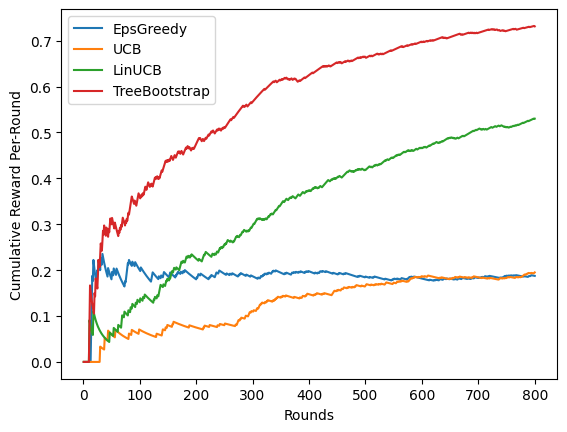

In [15]:
# plot cumulative reward per round 
eg_results, ucb_results, linucb_results, tbs_results, round_list = [], [], [], [], []  # create lists
n_rounds = 800                                       # the total number of rounds 
eg_sum, ucb_sum,linucb_sum, tbs_sum = 0, 0, 0, 0     # set the initial reward sum

# get the 800 results from the previous run per each algorithm 
for n_round in range(1, n_rounds + 1):              # start from 1 to avoid zero devision error
    eg_sum += results_EpsGreedy[n_round-1]
    ucb_sum += results_UCB[n_round-1]
    linucb_sum += results_LinUCB[n_round-1] 
    tbs_sum += results_TreeBootstrap[n_round-1]
    eg_results.append(eg_sum/n_round)
    ucb_results.append(ucb_sum/n_round)
    linucb_results.append(linucb_sum/n_round)
    tbs_results.append(tbs_sum/n_round)
    round_list.append(n_round)

# plot the results
plt.plot(round_list,eg_results, label = "EpsGreedy")
plt.plot(round_list,ucb_results, label = "UCB")
plt.plot(round_list,linucb_results, label = "LinUCB")
plt.plot(round_list,tbs_results, label = "TreeBootstrap")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()

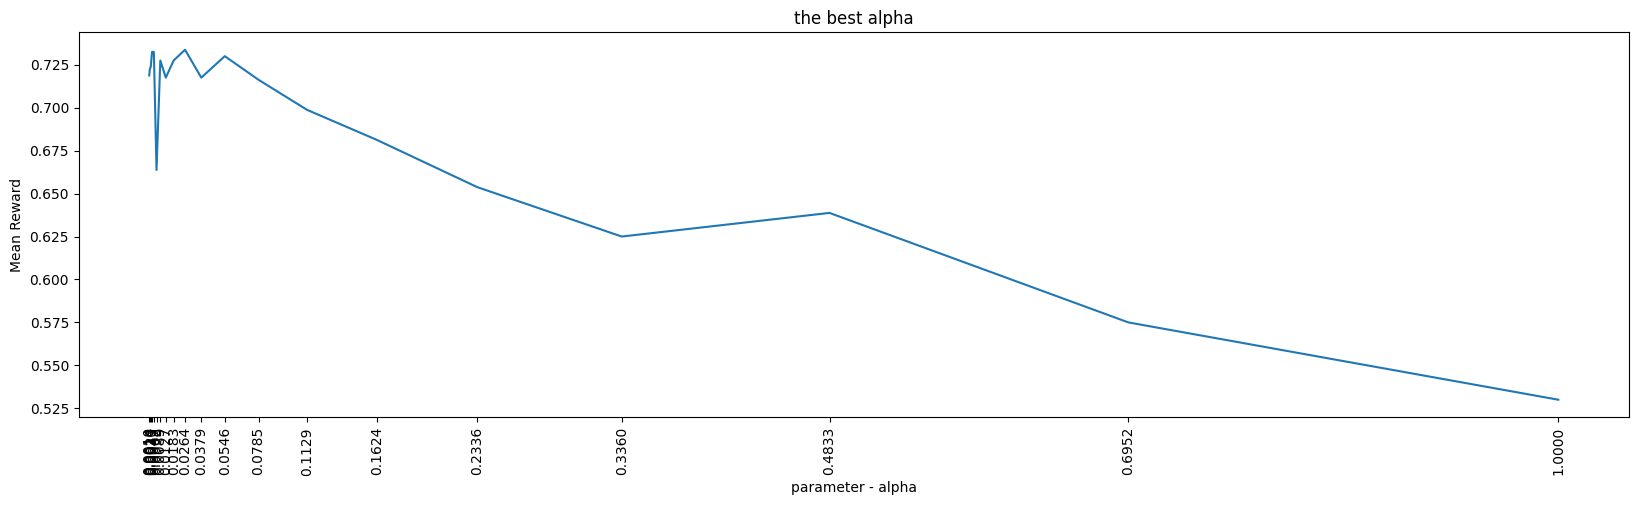

The best alpha for LinUCB is 0.026 with reward 0.73375


In [16]:
# hyperparameter optimization
alpha_list = np.logspace(-3,0,num= 20)    # generate valid alpha values
n_rounds = 800                            # set the initial number of round
max_reward = -np.inf                      # set the initial max reward
best_alpha = None                         # set the initial best alpha
results = []

# run with a set of alpha
for alpha in alpha_list:
    grid_mab = LinUCB(10, 10, alpha)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    results.append(temp_result)
    if temp_result > max_reward:  # get the maximum mean rewards with the best alpha
        best_alpha = alpha
        max_reward = temp_result


# show the plot
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(alpha_list,results)
plt.xticks(alpha_list, rotation = 'vertical')
plt.title('the best alpha')
plt.ylabel('Mean Reward')
plt.xlabel('parameter - alpha')
plt.show()
print("The best alpha for LinUCB is", round(best_alpha, 3), "with reward", max_reward)

#The best alpha for LinUCB is 0.026 with reward 0.73375

### KernelUCB (Kernel Upper Confidence Bound) Algorithm

**KernelUCB** is a contextual bandit algorithm that uses kernel methods to model non-linear relationships between context and rewards. It generalizes LinUCB to non-linear reward functions through the kernel trick.

**Key Features:**
- **Non-linear modeling**: Uses kernel functions (e.g., RBF) to capture non-linear patterns without explicitly computing high-dimensional feature maps
- **Kernel trick**: Leverages the kernel trick to work in an implicit high-dimensional feature space efficiently
- **Flexible kernels**: Supports various kernel functions (RBF, polynomial, etc.) allowing adaptation to different reward structures
- **Dual formulation**: Works in the dual space, making it efficient even with many historical observations

**How it works:**
- Maintains a kernel matrix K of similarities between historical contexts
- Uses kernel ridge regression to estimate reward functions in the implicit feature space
- Computes UCB using kernel-based confidence intervals: `UCB = μ(context) + α * sqrt(kernel_variance(context))`
- The kernel function (e.g., RBF) measures similarity between contexts, enabling non-linear reward modeling

**Advantages:**
- Captures complex non-linear relationships between context and rewards
- More flexible than linear methods while maintaining computational efficiency
- Kernel parameters (γ for RBF) control the smoothness and locality of the reward function
- Performs well when reward structure is non-linear but smooth


## 6. Implement KernelUCB contextual MAB

In [17]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        if not (type(gamma) == float  or gamma.dtype == 'float64'):
            raise TypeError("`gamma` must be float type")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be a real number")
        if not (type(eta) == float  or eta.dtype == 'float64'):
            raise TypeError("`eta` must be float type")    
        if not np.isreal(eta):
            raise ValueError("`eta` must be a real number")
            
        self.n_dims = n_dims                # the number of dimension
        self.gamma = gamma                  # regularization parameter
        self.eta  = eta                     # exploration parameter
        self.kern = kern                    # kernel function
        self.inv_K = None                   # inversed kernel matrices
        self.u = np.zeros(self.n_arms)      # upper bounds of probability
        self.y = np.empty(0)                # reward history
        self.pre_x = np.empty(0)            # collect the previous contexts(x) for b
        self.n_round = 0                    # count the number of round 
    
    # return the arm with the highest upper bounds of rewards
    def play(self, context):
        super().play(context)
        if self.n_round == 0:               # set the initial upper bound reward
            self.u[0] = 1.0
        else:
            k = self.kern(context, self.pre_x)         # calculate all kernel fn for previous contexts
            for arm in range(self.n_arms):
                shaped_context = context[arm].reshape(1, -1)
                sigma = np.sqrt(self.kern(shaped_context, shaped_context) - k[arm] @ self.inv_K  @ k[arm])   # calculate width (sigma)
                self.u[arm] = k[arm] @ self.inv_K @ self.y + (self.eta / np.sqrt(self.gamma)) * sigma        # calculate upper bound

        arm = break_tie(self.u)
        return arm
       
    def update(self, arm, reward, context):
        shaped_context = context[arm].reshape(1, -1)            # reshape context
        shaped_reward = np.array(reward).reshape(1, -1)         # reshape reward
   
        if self.n_round == 0:                                   # set the first values 
            self.y = shaped_reward
            self.pre_x = shaped_context
            self.K = self.kern(shaped_context, shaped_context) + self.gamma
            self.inv_K  = 1 / (self.K)                        
            
        else:
            self.y = np.r_[self.y, shaped_reward]               # update reward
            k = self.kern(context, self.pre_x)                  # calculate k (xa,t)
            b = k[arm].reshape(self.n_round, 1)
        
            bT_invK = b.T @ self.inv_K                          # previously calculate expensive calculation
            invK_b = self.inv_K  @ b
            K22 = np.linalg.inv(self.kern(shaped_context, shaped_context) + self.gamma - bT_invK @ b) 
            K11 = self.inv_K + K22 * invK_b @ bT_invK
            K12 = - K22 * invK_b
            K21 = - K22 * bT_invK
            
            self.pre_x = np.r_[self.pre_x, shaped_context]      # update previous context
            self.inv_K = np.vstack((np.hstack((K11, K12)), np.hstack((K21, K22))))    # update inverse K value
            
        self.n_round += 1
            
        

In [18]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.68


In [19]:
# hyperparameter optimization
gamma_list = np.linspace(0, 1, num = 11)[1:]       # generate valid gamma values & remove 0.0
eta_list = np.linspace(0, 0.5, num = 11)[1:]       # generate valid eta values & remove 0.0
n_rounds = 800                                     # set the initial number of round
gam_max_reward, eta_max_reward = -np.inf, -np.inf  # set the initial max reward for gamma and eta

# get the maximum mean rewards with the the initial eta
eta = 0.1
for gam in gamma_list:
    grid_mab = KernelUCB(10, 10, gam, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > gam_max_reward:      # get the maximum mean rewards with the best eta and gamma
        gam_max_reward = temp_result  
        best_gamma = gam

print("The best gamma for Kernel UCB is {", round(best_gamma, 3), "} with reward", gam_max_reward)

for eta in eta_list:
    grid_mab = KernelUCB(10, 10, best_gamma, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > eta_max_reward:   # get the maximum mean rewards with the best gamma
        eta_max_reward = temp_result
        best_eta =  eta
        
print("The best eta for Kernel UCB is {", round(best_eta, 3), "} with reward", eta_max_reward)


The best gamma for Kernel UCB is { 0.3 } with reward 0.785
The best eta for Kernel UCB is { 0.25 } with reward 0.77125


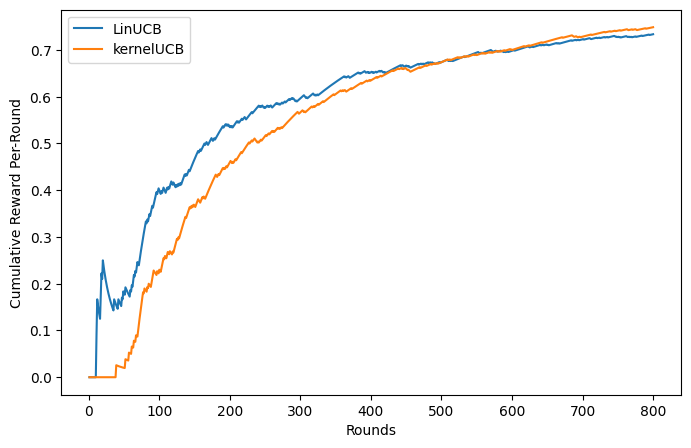

In [20]:
# your plotting code here LinUCB vs Kernel UCB
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds 
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(10, 10, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,800)

# run UCB algorithms
best_kernel_mab = KernelUCB(10, 10, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, 800)

for n_round in range(1, n_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1] 
    best_ker_sum += best_results_KernelUCB[n_round-1]
    
    # append ccumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot 
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()

## Conclusions

This project implemented and analyzed several Multi-Armed Bandit algorithms, demonstrating different approaches to the exploration-exploitation tradeoff in sequential decision-making.

### Key Findings

1. **Non-Contextual Algorithms:**
   - **ε-Greedy**: Simple and effective baseline that balances exploration and exploitation through a fixed probability parameter. Performs well when reward distributions are relatively stable.
   - **UCB (Upper Confidence Bound)**: Uses confidence intervals to naturally balance exploration and exploitation. Automatically reduces exploration as confidence in arm quality increases, leading to better long-term performance than ε-greedy in many scenarios.

2. **Contextual Algorithms:**
   - **LinUCB**: Leverages linear models to incorporate contextual information, significantly improving performance when context features are informative. The linear assumption works well when rewards have a linear relationship with context features.
   - **TreeBootstrap**: Uses decision trees to model non-linear relationships between context and rewards. Effective when the reward structure has complex, non-linear dependencies on context.
   - **KernelUCB**: Employs kernel methods to capture non-linear patterns in contextual bandits. Provides flexibility in modeling complex reward functions through kernel functions like RBF, potentially outperforming linear methods when relationships are highly non-linear.

3. **Performance Comparison:**
   - Contextual bandits generally outperform non-contextual algorithms when contextual information is available and informative
   - Among contextual methods, the best choice depends on the underlying reward structure:
     - Linear relationships favor LinUCB
     - Complex non-linear patterns may benefit from KernelUCB or TreeBootstrap
   - Hyperparameter tuning (e.g., exploration parameter α, kernel parameters γ and η) is crucial for optimal performance

4. **Exploration-Exploitation Tradeoff:**
   - All algorithms must balance exploring uncertain arms versus exploiting known good arms
   - Different algorithms achieve this balance through different mechanisms:
     - ε-greedy: Fixed exploration probability
     - UCB: Confidence-based exploration
     - Contextual methods: Context-aware exploration that adapts to available information

### Implementation Insights

- **From-scratch implementation** provides deep understanding of algorithm mechanics and mathematical foundations
- The abstract base class `MAB` design enables clean implementation of multiple algorithms with shared interface
- Offline evaluation methodology allows fair comparison of different algorithms on the same dataset
- Hyperparameter optimization reveals the sensitivity of each algorithm to its parameters

### Practical Applications

The implemented algorithms are directly applicable to real-world problems including:
- **Online advertising**: Selecting which ad to display to maximize click-through rates
- **Recommendation systems**: Choosing which items to recommend based on user context
- **Clinical trials**: Efficiently testing treatment options while maximizing patient outcomes
- **Resource allocation**: Optimizing resource distribution under uncertainty

### Future Directions

Potential extensions and improvements:
- Implementation of Thompson Sampling for Bayesian approaches
- Handling non-stationary environments where reward distributions change over time
- Multi-objective bandits for optimizing multiple criteria simultaneously
- Bandits with constraints (e.g., fairness, budget constraints)
- Deep learning integration for complex contextual representations
